# Example 8: Analysis Involving Multiple Tracers
In this example, we benchmark simulation results from PyTracerLab against equivalent results obtained from TracerLPM. We consider the tracer input data given in Example 1 of the TracerLPM documentation [(Jurgens et al., 2012)](https://pubs.usgs.gov/publication/tm4F3).

In [2]:
import PyTracerLab.model as ism
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
from datetime import datetime
import seaborn as sns
import pandas as pd


## 1. Load Observation Data

In [2]:
# load input series
# this would be the tracer concentration in precipitation or recharge in a
# practical problem
file_name = "TracerLPM_benchmark_input_multitracer.csv"
data = np.genfromtxt(
    file_name,
    delimiter=";",
    dtype=["<U7", float, float, float, float, float],
    encoding="utf-8",
    skip_header=1
)

timestamps = np.array([datetime.strptime(row[0], r"%Y-%m") for row in data])
# we only keep 3H and SF6
input_series = np.array([[row[1], row[2], row[5]] for row in data], dtype=float)

# load observation series
# this would be the measured tracer concentration in groudnwater in a
# practical problem
file_name = "TracerLPM_benchmark_observations_multitracer.csv"
data = np.genfromtxt(
    file_name,
    delimiter=";",
    dtype=["<U7", float, float, float, float, float],
    encoding="utf-8",
    skip_header=1
)

timestamps = np.array([datetime.strptime(row[0], r"%Y-%m") for row in data])
# we only keep 3H and SF6
obs_series = np.array([[row[1], row[2], row[5]] for row in data], dtype=float)

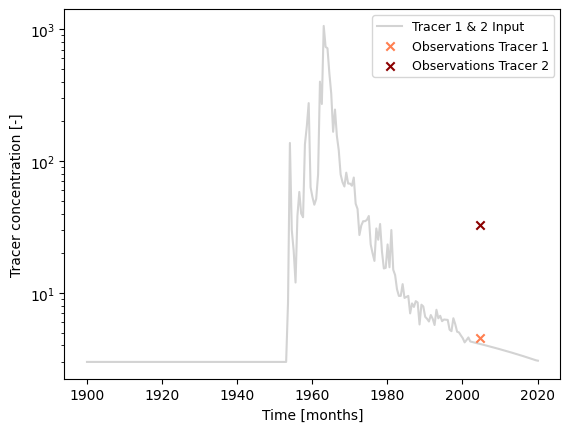

In [3]:
### plot input series, output series, and observations

# get observation timesteps
timesteps = [t.year + t.month / 12.0 for t in timestamps]

# create figure
fig, ax = plt.subplots(1, 1)
# plot input series
# this input is valid for both tracers
ax.plot(
    timesteps,
    input_series[:, 0],
    label="Tracer 1 & 2 Input",
    c="lightgrey"
)

# plot observations
ax.scatter(
    timesteps,
    obs_series[:, 0],
    label="Observations Tracer 1",
    color="coral",
    marker="x",
    zorder=10
)
ax.scatter(
    timesteps,
    obs_series[:, 1],
    label="Observations Tracer 2",
    color="darkred",
    marker="x",
    zorder=10
)

ax.set_xlabel("Time [months]")
ax.set_ylabel("Tracer concentration [-]")
ax.legend(ncol=1, fontsize=9)
ax.set_yscale("log")
plt.show()

## 2. Model Setup

In [129]:
t_half = 12.32 # tritium, in years
lambda_1 = np.log(2.0) / t_half

t_half = 1e10 # SF6 (which does not decay)
lambda_2 = np.log(2.0) / t_half

### define model (we do not use the same structure / units as the true model)
# time step is 6 months / 0.5 years
# because we use half life in years, we have to use a time step of 0.5
# if we were to give the half life in months, we would use a time step of 6
m = ism.Model(
    dt=0.5,
    lambda_=[lambda_1, lambda_1, lambda_2],
    input_series=input_series,
    target_series=obs_series,
    production=[False, True, False],
    steady_state_input=[3., 3., 0.], # this is the true value
    n_warmup_half_lives=10,
    n_warmup_steps=100
)

# add a dispersion model unit
# define the initial model parameters for inference
dm_mtt_init = 10
dm_dp_init = 0.8
m.add_unit(
    ism.DMUnit(mtt=dm_mtt_init, DP=dm_dp_init),
    fraction=1.,
    bounds=[(1.0, 1000.), (0.01, 10.0)],
    prefix="dm"
)

## 3. Model Simulation for Different Mean Travel Times

In [130]:
# Define range of mean travel times to consider
# mtt_range = np.linspace(1, 250, 150)
# mtt_range = np.arange(1., 250., 10)
mtt_range = np.logspace(0., 2.35, 91)
mtt_range = np.logspace(0., 2.7, 91)

# Create empty array of results
results = np.zeros((3, len(mtt_range), len(input_series)))

# Iterate over mean travel times
for i, mtt in enumerate(mtt_range):
    m.set_param(key="dm.mtt", value=mtt)
    sim = m.simulate()
    results[0, i, :] = sim[:, 0].flatten()
    results[1, i, :] = sim[:, 1].flatten()
    results[2, i, :] = sim[:, 2].flatten()


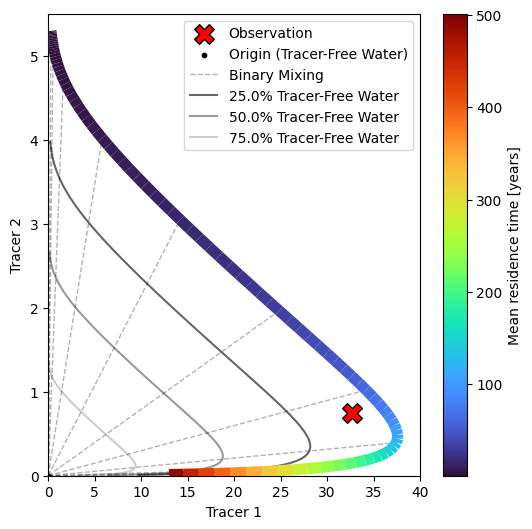

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Get indices of time series that have observations
obs_indices = np.arange(len(timestamps))[~np.isnan(obs_series).any(axis=1)]

# select index of observation date
idx_select = 0

tracer1_col = 1
tracer2_col = 2

# --- multicolored line (instead of colored points) ---
x = results[tracer1_col, :, obs_indices[idx_select]]
y = results[tracer2_col, :, obs_indices[idx_select]]

# build line segments between consecutive points
points = np.column_stack([x, y])                       # (N, 2)
segments = np.stack([points[:-1], points[1:]], axis=1) # (N-1, 2, 2)

# color each segment by mean residence time (use midpoint value per segment)
mtt_seg = 0.5 * (mtt_range[:-1] + mtt_range[1:])       # (N-1,)
norm = Normalize(vmin=np.nanmin(mtt_range), vmax=np.nanmax(mtt_range))

lc = LineCollection(
    segments,
    cmap="turbo",
    norm=norm,
    linewidths=8.0,
    zorder=10,
)
lc.set_array(mtt_seg)
ax.add_collection(lc)

# (optional) black outline behind for contrast
# ax.plot(x, y, c="k", lw=9., alpha=0.6, zorder=9)

# plot the observation
ax.scatter(
    obs_series[obs_indices[idx_select], tracer1_col],
    obs_series[obs_indices[idx_select], tracer2_col],
    c="r",
    edgecolor="k",
    marker="X",
    zorder=20,
    s=200,
    label="Observation"
)

# plot the origin point
ax.scatter(
    [0.],
    [0.],
    c="k",
    edgecolor="k",
    marker="o",
    zorder=20,
    s=10,
    label="Origin (Tracer-Free Water)"
)

# plot straight lines from the origin to the points representing the different mean travel times
stepper = 10  # plot line from origin to every stepper point
points_idx = [i for i in range(len(mtt_range))][::stepper]
for i in points_idx:
    label = "Binary Mixing" if i == points_idx[0] else None
    ax.plot(
        [0., results[tracer1_col, i, obs_indices[idx_select]]],
        [0., results[tracer2_col, i, obs_indices[idx_select]]],
        c="k",
        lw=1.,
        alpha=0.3,
        ls="--",
        label=label
    )

# plot path between points representing the different mean travel times but multiplied by a range of dilution factors
percent_tracer_free = [.75, .5, .25]
for p in percent_tracer_free:
    ax.plot(
        x * p,
        y * p,
        c="k",
        lw=1.5,
        alpha=0.8 * p,
        label=f"{(1-p)*100}% Tracer-Free Water"
    )

ax.set_xlim(0., 40.)
ax.set_ylim(0., 5.5)

plt.colorbar(lc, ax=ax, label="Mean residence time [years]")
ax.set_xlabel("Tracer 1")
ax.set_ylabel("Tracer 2")
ax.legend()
ax.set_title(f"Date of Observation: {timestamps[obs_indices[idx_select]].date()}")
ax.set_title("")
plt.show()


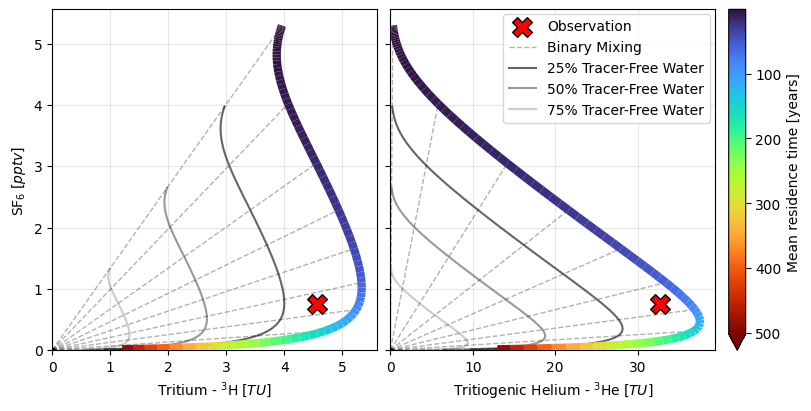

<Figure size 640x480 with 0 Axes>

In [136]:
def add_mtt_colored_line_plot(
    ax,
    results,
    mtt_range,
    obs_series,
    timestamps,
    obs_indices,
    idx_select,
    tracer1_col=1,
    tracer2_col=2,
    *,
    cmap="turbo",
    line_lw=4.0,
    outline=True,
    outline_lw=5.5,
    outline_alpha=0.6,
    stepper=10,
    percent_tracer_free=(0.75, 0.5, 0.25),
):
    # extract curve for selected observation date
    x = results[tracer1_col, :, obs_indices[idx_select]]
    y = results[tracer2_col, :, obs_indices[idx_select]]

    # multicolored line segments
    pts = np.column_stack([x, y])
    segs = np.stack([pts[:-1], pts[1:]], axis=1)
    mtt_seg = 0.5 * (mtt_range[:-1] + mtt_range[1:])

    lc = LineCollection(segs, cmap=cmap, linewidths=line_lw, zorder=10)
    lc.set_array(mtt_seg)  # norm will be set outside for shared colorbar
    ax.add_collection(lc)

    if outline:
        ax.plot(x, y, c="k", lw=outline_lw, alpha=outline_alpha, zorder=9)

    # observation
    ax.scatter(
        obs_series[obs_indices[idx_select], tracer1_col],
        obs_series[obs_indices[idx_select], tracer2_col],
        c="r",
        edgecolor="k",
        marker="X",
        zorder=20,
        s=200,
        label="Observation",
    )

    # origin
    ax.scatter(
        [0.0],
        [0.0],
        c="k",
        edgecolor="k",
        marker="o",
        zorder=20,
        s=10,
        # label="Origin (Tracer-Free Water)",
    )

    # binary mixing rays
    points_idx = list(range(len(mtt_range)))[::stepper]
    points_idx = [0, -1, 30, 40, 47, 53, 59, 65, 72]
    for i in points_idx:
        label = "Binary Mixing" if i == points_idx[0] else None
        ax.plot(
            [0.0, results[tracer1_col, i, obs_indices[idx_select]]],
            [0.0, results[tracer2_col, i, obs_indices[idx_select]]],
            c="k",
            lw=1.0,
            alpha=0.3,
            ls="--",
            label=label,
        )

    # dilution factors
    for p in percent_tracer_free:
        ax.plot(
            x * p,
            y * p,
            c="k",
            lw=1.5,
            alpha=0.8 * p,
            label=f"{(1 - p) * 100:.0f}% Tracer-Free Water",
        )

    # ax.set_xlabel("Tracer 1")
    # ax.set_ylabel("Tracer 2")
    # ax.set_title(
    #     f"{title_prefix}Date of Observation: {timestamps[obs_indices[idx_select]].date()}"
    # )

    return lc  # return mappable for shared colorbar

fig, ax = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True, sharey=True)
axs = np.ravel(ax)

# Get indices of time series that have observations (shared across all)
obs_indices = np.arange(len(timestamps))[~np.isnan(obs_series).any(axis=1)]
idx_select = 0

# shared normalization (same color mapping across all subplots)
norm = Normalize(vmin=np.nanmin(mtt_range), vmax=np.nanmax(mtt_range))

tracer1_cols = [0, 1]
tracer2_cols = [2, 2]
mappables = []
for i, ax in enumerate(axs):
    lc = add_mtt_colored_line_plot(
        ax,
        results,
        mtt_range,
        obs_series,
        timestamps,
        obs_indices,
        idx_select,
        tracer1_col=tracer1_cols[i],
        tracer2_col=tracer2_cols[i],
        outline=False,
        line_lw=6.
    )
    lc.set_norm(norm)  # enforce shared normalization
    mappables.append(lc)
    ax.set_xlim(0.)
    ax.set_ylim(0.)

# shared colorbar (use any of the LineCollections as the mappable)
cbar = fig.colorbar(
    mappables[0],
    ax=axs,
    label="Mean residence time [years]",
    fraction=0.035,
    pad=0.02,
    extend="max"
)
cbar.ax.invert_yaxis()

# legend: usually best to show it only once to avoid clutter
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(.62, .7), ncol=1, frameon=True)

axs[0].set_xlabel(r"Tritium - $ ^3\mathrm{H} \; [TU] $")
axs[0].set_ylabel(r"$ \mathrm{SF}_6 \; [pptv] $")
axs[0].grid(True, alpha=0.3)
axs[1].set_xlabel(r"Tritiogenic Helium - $ ^3\mathrm{He} \; [TU] $")
axs[1].grid(True, alpha=0.3)

plt.show()

plt.savefig("tracer_tracer_plots_benchmark.png", dpi=600)


## 4. Model Inversion with MCMC

In [120]:
# sample from parameter posterior
# create a solver
solver = ism.Solver(m)
# run MCMC
res = solver.dream_sample(
    n_samples=5000, # effective samples after burn-in and thinning
    burn_in=5000,
    thin=1,
    sigma=[1., 1., 0.5],
    random_state=42,
    return_sim=True,
    set_model_state=False,
    n_diff_pairs=1
)
print(res["gelman_rubin"])

{'dm.DP': 1.0061710929823868, 'dm.mtt': 1.0086201133530182}


In [121]:
res["posterior_map"]

{'dm.DP': 9.924131991504817, 'dm.mtt': 781.7050585416031}

Text(0.5, 0, 'Steps')

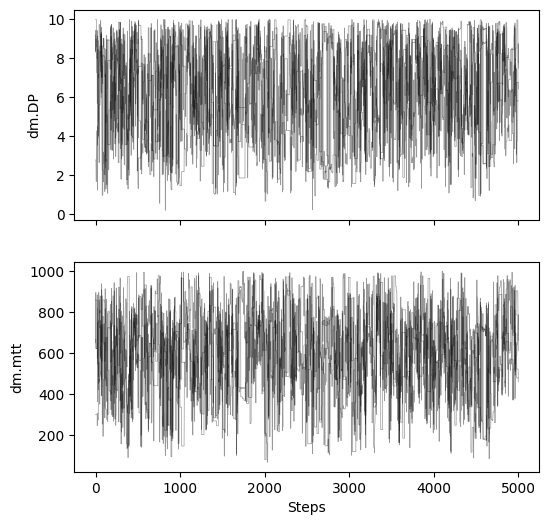

In [122]:
# plot chains to inspect convergence
fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

for i in range(res["samples_chain"].shape[2]):
    for j in range(res["samples_chain"].shape[0]):
        ax[i].plot(res["samples_chain"][j, :, i], c="k", lw=.5, alpha=0.4)
    ax[i].set_ylabel(m.param_keys(free_only=True)[i])
ax[-1].set_xlabel("Steps")

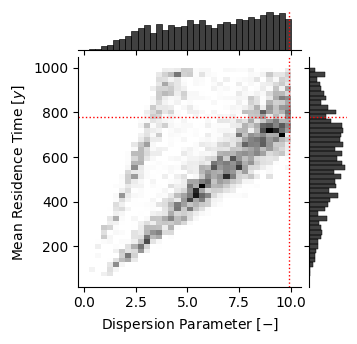

In [127]:
# make dict from sample array
sample_df = pd.DataFrame({
    "DP": res["samples"][::1, 0],
    "MTT": res["samples"][::1, 1],
})

# p = sns.jointplot(sample_df, x="DP", y="MTT", kind="kde", height=3.5, cmap="binary",
#               fill=True, levels=7, linewidths=2., thresh=0.02,
#               marginal_kws={"color": "k", "fill": True})
p = sns.jointplot(sample_df, x="DP", y="MTT", kind="hist", height=3.5, cmap="binary",
              fill=True, thresh=0.02,
              marginal_kws={"color": "k", "fill": True})
# p.plot_joint(sns.kdeplot, color="k", zorder=10000, levels=7, linewidths=0.5, thresh=0.02)
p.refline(x=res["posterior_map"]["dm.DP"], y=res["posterior_map"]["dm.mtt"], color="r", lw=1., ls=":")
p.set_axis_labels(r"Dispersion Parameter $ [-] $", r"Mean Residence Time $ [y] $")

plt.savefig("joint_posterior_benchmark.png", dpi=600)

C:\Users\MRudolph\AppData\Local\Temp\ipykernel_18196\330341518.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r"$ ^3\mathrm{H} \; [TU] $", r"$ ^3\mathrm{He} \; [TU] $", r"$ \mathrm{SF}_6 \; [pptv] $"])


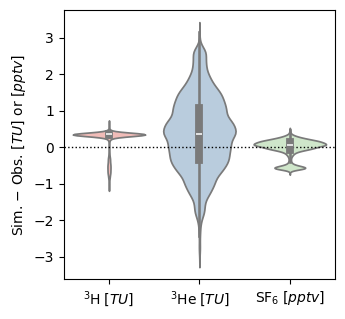

In [128]:
# Get indices of time series that have observations (shared across all)
obs_indices = np.arange(len(timestamps))[~np.isnan(obs_series).any(axis=1)]
idx_select = 0

# Get posterior simulations
sim_data = res["sims"][:, :, obs_indices[idx_select], :]
sim_data = sim_data.reshape((-1, sim_data.shape[-1]))
obs_data = obs_series[obs_indices[idx_select], :]

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))

ax.axhline(0, ls=":", c="k", lw=1.)
p = sns.violinplot(
    data=sim_data - obs_data, ax=ax, palette="Pastel1")
ax.set_xticklabels([r"$ ^3\mathrm{H} \; [TU] $", r"$ ^3\mathrm{He} \; [TU] $", r"$ \mathrm{SF}_6 \; [pptv] $"])
ax.set_ylabel(r"Sim. $ - $ Obs. $  [TU] $ or $ [pptv] $")

plt.savefig("errors_benchmark.png", dpi=600)